In [1]:
using Plots

include("../src/Schemish.jl")
using .Schemish

include("../src/AdvancedTensors.jl")
using .Tensors
import .Tensors:sum  # replace Base.sum

include("../src/IrisDataset.jl")
using .IrisDataset

include("../src/MorseDataset.jl")
using .MorseDataset

# 1 - The Lines Sleep Tonight

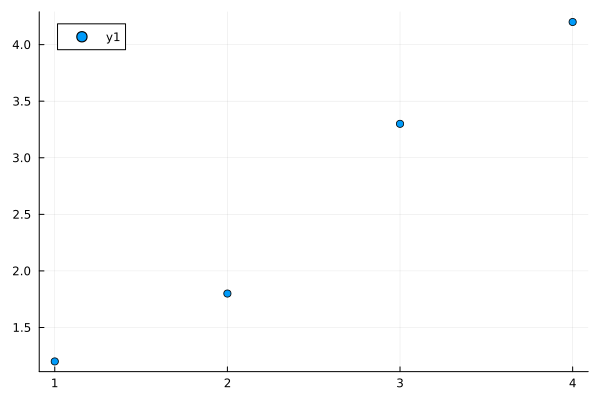

In [2]:
line_xs = tensor([2.0, 1.0, 4.0, 3.0])
line_ys = tensor([1.8, 1.2, 4.2, 3.3])

plot(line_xs.elements, line_ys.elements, seriestype=:scatter)

In [3]:

# frame 26:25

line(x) = (θ) -> ref(θ, 0) * x + ref(θ, 1)

line (generic function with 1 method)

In [4]:
line(5)(list(1, 2))

7

# 2 - The More We Learn, the Tenser We Become

In [5]:
@assert is_scalar(9)
@assert is_scalar(3.1415)
@assert !is_scalar(tensor([1]))
@assert tlen(tensor([17, 12, 91, 67])) == 4
@assert tlen(tensor([[3, 2, 8], [7, 1, 9]])) == 2

In [6]:

# frame 39:37

function shape(t)
    result = list()
    while !is_scalar(t)
        # the iterative implementation requires us to append to the list,
        # in contrast to the book's recursive implementation that prepends.
        result = snoc(result, tlen(t))
        t = tref(t, 0)
    end
    result
end

shape (generic function with 1 method)

In [7]:
@assert shape(9) == list()
@assert shape(tensor([9, 4, 7, 8, 0, 1])) == list(6)
@assert shape(tensor([[[5], [6], [8]], [[7], [9], [5]]])) == list(2, 3, 1)

In [8]:

# frame 42:44

function rank(t)
    result = 0
    while !is_scalar(t)
        # this is mostly equivalent to the books accumulator passing style;
        # we just mutate the accumulator in place.
        result += 1
        t = tref(t, 0)
    end
    result
end

rank (generic function with 1 method)

In [9]:
@assert rank(9) == 0
@assert rank(tensor([9, 4, 7, 8, 0, 1])) == 1
@assert rank(tensor([[[5], [6], [8]], [[7], [9], [5]]])) == 3

# Interlude I - The More We Extend, the Less Tensor We Get

In [10]:
tensor([5, 6, 7]) + tensor([2, 0, 1])

[7.0 6.0 8.0]

In [11]:
@assert tensor([5, 6, 7]) + tensor([2, 0, 1]) == tensor([7, 6, 8])
@assert 4 + tensor([3, 6, 5]) == tensor([7, 10, 9])
@assert tensor([6, 9, 1]) + tensor([[4, 3, 8], [7, 4, 7]]) == tensor([[10, 12, 9], [13, 13, 8]])
@assert tensor([[4, 6, 5], [6, 9, 7]]) * 3 == tensor([[12, 18, 15], [18, 27, 21]])

@assert sqrt(tensor([9, 16, 25])) == tensor([3, 4, 5])
@assert sqrt(tensor([[49, 81, 16], [64, 25, 36]])) == tensor([[7, 9, 4], [8, 5, 6]])

In [12]:
@assert sum_1(tensor([10.0, 12.0, 14.0])) == 36.0
@assert sum(tensor([[[1, 2], [3, 4]], [[5, 6], [7, 8]]])) == tensor([[3, 7], [11, 15]])

In [13]:
line(tensor([2, 7, 5, 11]))(list(4, 6))

[14.0 34.0 26.0 50.0]

# 3 - Running Down a Slippery Slope

In [14]:

# frame 63:22

l2_loss(target) = (xs, ys) -> (θ) -> sum(sqr(ys - target(xs)(θ)))

l2_loss (generic function with 1 method)

In [15]:
expectant = l2_loss(line)
objective = expectant(line_xs, line_ys)
loss_0 = objective(list(0.0, 0.0))

33.21

In [16]:
loss_0_ = objective(list(0.0099, 0.0))
rate_of_change = (loss_0_ - loss_0) / 0.0099
θ0_1 = 0.0 - rate_of_change * 0.01
loss_1 = objective(list(θ0_1, 0.0))

5.502108626999984

In [17]:
loss_1_ = objective(list(θ0_1 + 0.0099, 0.0))
rate_of_change = (loss_1_ - loss_1) / 0.0099

-25.08119999999999

As we see, the rate of change depends on the current θ...

# 4 - Slip-slidin' Away

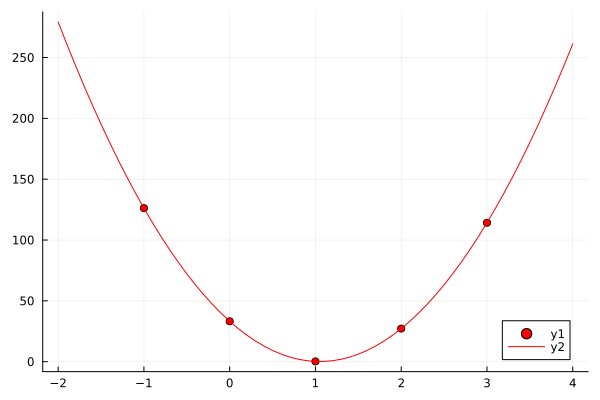

In [18]:
let θ0s = [-1, 0, 1, 2, 3]
    let losses = [objective(list(θ0, 0.0)) for θ0 in θ0s]
        plot(θ0s, losses, seriestype=:scatter, color=:red)
    end
end

let θ0s = -2:0.1:4
    let losses = [objective(list(θ0, 0.0)) for θ0 in θ0s]
        plot!(θ0s, losses, color=:red)
    end
end

In [19]:
@assert gradient_of((θ) -> sqr(ref(θ, 0)), list(27)) == list(54)

In [20]:

#gradient_of((θ) -> sum(sqr((line_xs*ref(θ, 0)) + ref(θ,1) - line_ys)), list(0.0, 0.0))

gradient_of((θ) -> ((line_xs+ref(θ, 0)) + ref(θ,1)), list(0.0, 0.0))

(4.0, [1.0 1.0 1.0 1.0])

In [21]:
@assert gradient_of(objective, list(0.0, 0.0)) == list(-63.0, -21.0)

AssertionError: AssertionError: gradient_of(objective, list(0.0, 0.0)) == list(-63.0, -21.0)

In [22]:

# frame 80:24

function revise(f, revs, θ)
    for _ in 1:revs
        θ = f(θ)
    end
    return θ
end

revise (generic function with 1 method)

In [23]:
@assert revise((θ) -> map((p) -> p - 3, θ), 5, list(1, 2, 3)) == list(-14, -13, -12)

In [24]:
θ = let α = 0.01, obj = l2_loss(line)(line_xs, line_ys)
    function f(θ)
        gs = ∇(obj, θ)
        list(ref(θ, 0) - α * ref(gs, 0),
            ref(θ, 1) - α * ref(gs, 1))
    end
    revise(f, 1000, list(0.0, 0.0))
end


(1.0161290322580645, [-0.23 0.18 0.14 0.25])

In [25]:
plot(line_xs.elements, line_ys.elements, seriestype=:scatter)
plot!([0, 5], [ref(θ, 0) * x + ref(θ, 1) for x in [0, 5]])

ErrorException: Cannot convert Main.Tensors.MyTensor to series data for plotting

In [26]:
α = 0.01
revs = 1000

function gradient_descent(obj, θ)
    function f(Θ)
        gs = ∇(obj, Θ)
        map((p, g) -> p - α * g, Θ, ∇(obj, Θ))
    end
    revise(f, revs, θ)
end

gradient_descent(l2_loss(line)(line_xs, line_ys), list(1.0, 0.0))

(1.0483870967741935, [-0.3 0.15 0.01 0.15])

# Interlude II - Too Many Toys Make Us Hyperactive

In [27]:
smaller = nothing
larger = nothing

@assert @with_hypers(smaller, 1,
    larger, 2000,
    smaller + larger
) == 2001

@with_hypers(smaller, 1,
    larger, 2000,
    begin
        @with_hypers(smaller, 5,
            larger, 6,
            println(smaller + larger)
        )
        println(smaller + larger)
    end
)

11
2001


# 5 - Target Practice

In [28]:
α = nothing     # hyperparameter
revs = nothing  # hyperparameter

@with_hypers(α, 0.01, revs, 1000,
    gradient_descent(
        l2_loss(line)(line_xs, line_ys),
        list(0.0, 0.0)
    )
)

(1.0161290322580645, [-0.23 0.18 0.14 0.25])

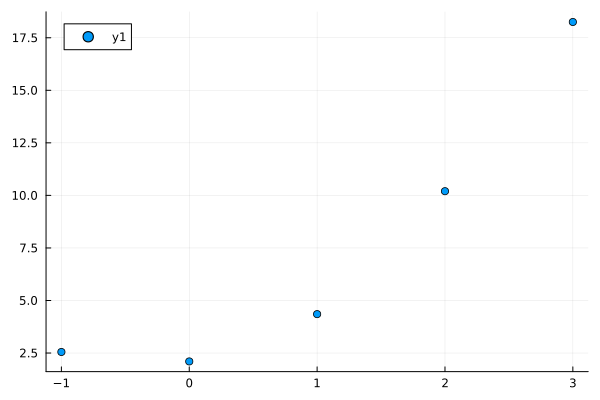

In [29]:
quad_xs = tensor([-1.0, 0.0, 1.0, 2.0, 3.0])
quad_ys = tensor([2.55, 2.1, 4.35, 10.2, 18.25])

plot(quad_xs.elements, quad_ys.elements, seriestype=:scatter)

In [30]:

# frame 102:15

quad(t) = (θ) -> ref(θ, 0) * sqr(t) + ref(θ, 1) * t + ref(θ, 2)

quad (generic function with 1 method)

In [31]:
@with_hypers(
    revs, 1000,
    α, 0.001,
    gradient_descent(
        l2_loss(quad)(quad_xs, quad_ys),
        list(0.0, 0.0, 0.0)
    )
)

(1.861225819157954, 0.7379286861964469, [1.23 1.82 1.52 1.12 -0.6])

In [32]:
plane_xs = tensor([
    [1.0, 2.05],
    [1.0, 3.0],
    [2.0, 2.0],
    [2.0, 3.91],
    [3.0, 6.13],
    [4.0, 8.09]
])

plane_ys = tensor([13.99, 15.99, 18.0, 22.4, 30.2, 37.94])

[13.99 15.99 18.0 22.4 30.2 37.94]

In [33]:

# frame 105:25

plane(t) = (θ) -> dot_product(ref(θ, 0), t) + ref(θ, 1)

plane (generic function with 1 method)

In [34]:
dot_product_1_1

(::Main.Tensors.var"#inner#57"{typeof(Main.Tensors.dot_product_1_1ρ), typeof(Main.Tensors.dot_product_1_1∇)}) (generic function with 5 methods)

In [35]:

# frame 106:26

#dot_product_1_1(w, t) = sum_1(w * t)

# frame 190:43

dot_product = ext2(dot_product_1_1, 1, 1)

(::Main.Tensors.var"#inner#57"{Main.Tensors.var"#extended#15"{typeof(Main.Tensors.dot_product_1_1ρ), Int64, Int64}, Main.Tensors.var"#extended#21"{typeof(Main.Tensors.dot_product_1_1∇), Int64, Int64}}) (generic function with 5 methods)

In [36]:
@assert dot_product(tensor([2.0, 1.0, 7.0]), tensor([8.0, 4.0, 3.0])) == 41.0
@assert dot_product(
    tensor([1, 2]),
    tensor([tensor([1, 2]), tensor([3, 4]), tensor([5, 6])])
) == tensor([5, 11, 17])

In [37]:
@with_hypers(
    revs, 1000,
    α, 0.001,
    gradient_descent(
        l2_loss(plane)(plane_xs, plane_ys),
        list(tensor([0.0, 0.0]), 0.0)
    )
)

([4.04 3.07], [3.16 2.28 3.48 2.03 -0.63 -2.63])

# 6 - An Appla a Day

In [38]:

# frame 123:24

function samples(n, s)
    list(rand(0:n-1, s)...)
end

samples (generic function with 1 method)

In [39]:
@assert trefs(tensor([5.0, 2.8, 4.2, 2.3, 7.4, 1.7, 8.1]), list(6, 0, 3, 1)) == tensor([8.1, 5.0, 2.3, 2.8])

In [40]:
batch_size = nothing  # hyperparameter

In [41]:

# frame 127:36

function sampling_obj(expectant, xs, ys)
    n = tlen(xs)
    (θ) -> let b = samples(n, batch_size)
        expectant(trefs(xs, b), trefs(ys, b))(θ)
    end
end

sampling_obj (generic function with 1 method)

In [42]:
@with_hypers(
    revs, 1000,
    α, 0.01,
    batch_size, 4,
    gradient_descent(
        sampling_obj(
            l2_loss(line), line_xs, line_ys),
        list(0.0, 0.0)
    )
)

(1.0390623939209473, [0.02 0.01 0.03 0.01])

In [43]:
@with_hypers(
    revs, 15000,
    α, 0.001,
    batch_size, 4,
    gradient_descent(
        sampling_obj(
            l2_loss(plane), plane_xs, plane_ys),
        list(tensor([0.0, 0.0]), 0.0)
    )
)

([3.98 1.97], [6.15 6.15 6.15 6.17])

# 7 - The Crazy "ates"

In [44]:
# Here, I'll take a more Julia-style approach to defining the three "ates"
struct Lonely end
inflate(::Lonely) = (θ) -> map(list, θ)
deflate(::Lonely) = (Θ) -> map(first, Θ)
update(::Lonely) = (Θ, gs) -> map((p, g) -> list(ref(p, 0) - α * g), Θ, gs)


update (generic function with 1 method)

In [45]:
# the penultimate gradient-descent from frame 137:22
function gradient_descent(parameter_representation)
    inflate_fn = inflate(parameter_representation)
    deflate_fn = deflate(parameter_representation)
    update_fn = update(parameter_representation)
    (obj, θ) -> let f = (Θ) -> update_fn(Θ, (∇(obj, deflate_fn(Θ))))
        deflate_fn(revise(f, revs, inflate_fn(θ)))
    end
end


gradient_descent (generic function with 2 methods)

In [46]:
function try_plane(a_gradient_descent)
    @with_hypers(
        revs, 15000,
        α, 0.001,
        batch_size, 4,
        a_gradient_descent(
            sampling_obj(
                l2_loss(plane),
                plane_xs, plane_ys),
            list(tensor([0.0, 0.0]), 0.0)))
end

try_plane (generic function with 1 method)

In [47]:
try_plane(gradient_descent(Lonely()))

([3.99 1.97], [6.15 6.14 6.14 6.16])

In [48]:
struct Naked end
inflate(::Naked) = (θ) -> map((p) -> p, θ)
deflate(::Naked) = (Θ) -> map((p) -> p, Θ)
update(::Naked) = (Θ, gs) -> map((p, g) -> (p - α * g), Θ, gs)

try_plane(gradient_descent(Naked()))

([3.99 1.97], [6.14 6.14 6.15 6.15])

In [49]:

# frame 141:38

function gradient_descent(parameter_representation)
    inflate_fn = inflate(parameter_representation)
    deflate_fn = deflate(parameter_representation)
    update_fn = update(parameter_representation)
    (obj, θ) -> let f = (Θ) -> map(update_fn, Θ, ∇(obj, map(deflate_fn, Θ)))
        map(deflate_fn, revise(f, revs, map(inflate_fn, θ)))
    end
end

gradient_descent (generic function with 2 methods)

In [50]:
inflate(::Lonely) = (p) -> list(p)
deflate(::Lonely) = (P) -> first(P)
update(::Lonely) = (P, g) -> list(first(P) - α * g)

try_plane(gradient_descent(Lonely()))

([3.98 1.97], [6.15 6.14 6.16 6.16])

In [51]:
inflate(::Naked) = (p) -> p
deflate(::Naked) = (P) -> P
update(::Naked) = (P, g) -> P - α * g

# frame 143:43
naked_gradient_descent = gradient_descent(Naked())

try_plane(naked_gradient_descent)

([3.98 1.97], [6.15 6.15 6.16 6.16])

# 8 - The Nearer Your Destination, the Slower You Become

In [52]:
# frame 149:21
μ = nothing  # hyperparameter; the recommendat value is usually about 0.9

In [53]:
struct Velocity end
inflate(::Velocity) = (p) -> list(p, zeroes(p))
deflate(::Velocity) = (P) -> first(P)
update(::Velocity) = (P, g) -> let v = μ * ref(P, 1) - α * g
    list(first(P) + v, v)
end

velocity_gradient_descent = gradient_descent(Velocity())

#65 (generic function with 1 method)

In [54]:
function try_plane(a_gradient_descent, a_revs)
    @with_hypers(
        revs, a_revs,
        α, 0.001,
        batch_size, 4,
        a_gradient_descent(
            sampling_obj(
                l2_loss(plane),
                plane_xs, plane_ys),
            list(tensor([0.0, 0.0]), 0.0)))
end

try_plane (generic function with 2 methods)

In [55]:
@with_hypers μ 0.9 begin
    try_plane(velocity_gradient_descent, 5000)
end

StackOverflowError: StackOverflowError:

# Interlude IV - Smooth Operator

In [56]:

# frame 155:3

function smooth(decay_rate, average, g)
    decay_rate * average + (1 - decay_rate) * g
end

smooth (generic function with 1 method)

# 9 - Be Adamant

In [57]:
β = nothing  # hyperparameter for the decay rate of the adaptive update rate

ε = 1e-8  # the "stabilizer" -- not a hyperparameter

1.0e-8

In [58]:
struct RMS end
inflate(::RMS) = (p) -> list(p, zeroes(p))
deflate(::RMS) = (P) -> first(P)
update(::RMS) = (P, g) ->
    let r = smooth(β, ref(P, 1), sqr(g))
        let α = α / (sqrt(r) + ε)
            list(first(P) - α * g, r)
        end
    end

# frame 169:29
rms_gradient_descent = gradient_descent(RMS())

#65 (generic function with 1 method)

In [59]:
function try_plane(a_gradient_descent, a_revs, an_α)
    @with_hypers(
        revs, a_revs,
        α, an_α,
        batch_size, 4,
        a_gradient_descent(
            sampling_obj(
                l2_loss(plane),
                plane_xs, plane_ys),
            list(tensor([0.0, 0.0]), 0.0)))
end

try_plane (generic function with 3 methods)

In [60]:
@with_hypers β 0.9 begin
    try_plane(rms_gradient_descent, 3000, 0.01)
end

StackOverflowError: StackOverflowError:

In [61]:
struct Adam end
inflate(::Adam) = (p) -> let v = zeroes(p)
    list(p, v, v)
end
deflate(::Adam) = (P) -> first(P)
update(::Adam) = (P, g) ->
    let r = smooth(β, ref(P, 2), sqr(g))
        let α = α / (sqrt(r) + ε)
            v = smooth(μ, ref(P, 1), g)
            list(ref(P, 0) - α * v, v, r)
        end
    end

# frame 173:42
adam_gradient_descent = gradient_descent(Adam())

#65 (generic function with 1 method)

In [62]:
@with_hypers μ 0.85 β 0.9 begin
    try_plane(adam_gradient_descent, 1500, 0.01)
end

StackOverflowError: StackOverflowError:

# Interlude V - Extensio Magnifico

In [63]:
@assert zeroes(tensor([tensor([1]), tensor([2])])) == zeroes(tensor([tensor([0]), tensor([0])]))

StackOverflowError: StackOverflowError:

In [64]:

#frame 184:27

flatten = ext1(flatten_2, 2)

MethodError: MethodError: no method matching flatten_2(::String)

Closest candidates are:
  flatten_2(!Matched::Main.Tensors.MyTensor)
   @ Main.Tensors ~/git-working/the-little-learner/src/AdvancedTensors.jl:39


In [65]:
@assert flatten_2(tensor([tensor([1]), tensor([2])])) == tensor([1, 2])
@assert flatten(tensor([tensor([tensor([1]), tensor([2])]), tensor([tensor([3]), tensor([4])])])) == tensor([tensor([1, 2]), tensor([3, 4])])

UndefVarError: UndefVarError: `flatten` not defined

In [66]:

# frame 190:44

mul_1_1 = ext2(*, 1, 1)
mul_2_1 = ext2(mul_1_1, 2, 1)

(::Main.Tensors.var"#inner#57"{Main.Tensors.var"#extended#15"{Main.Tensors.var"#extended#15"{String, Int64, Int64}, Int64, Int64}, Main.Tensors.var"#extended#21"{Main.Tensors.var"#extended#21"{String, Int64, Int64}, Int64, Int64}}) (generic function with 5 methods)

In [67]:
@assert (
    mul_2_1(
        tensor([tensor([3, 4, 5]), tensor([7, 8, 9])]),
        tensor([2, 4, 3]))
    ==
    tensor([tensor([6, 16, 15]), tensor([14, 32, 27])]))

@assert (
    mul_2_1(
        tensor([tensor([8, 1]), tensor([7, 3]), tensor([5, 4])]),
        tensor([tensor([6, 2]), tensor([4, 9]), tensor([3, 8])]))
    ==
    tensor([
        tensor([tensor([48, 2]), tensor([42, 6]), tensor([30, 8])]),
        tensor([tensor([32, 9]), tensor([28, 27]), tensor([20, 36])]),
        tensor([tensor([24, 8]), tensor([21, 24]), tensor([15, 32])])]))


MethodError: MethodError: objects of type String are not callable

# 10 - Doing the Neuron Dance

In [68]:

# frame 196:9

rectify_0(s) = s < 0.0 ? 0.0 : s

# frame 197:11
rectify(t) = ext1(rectify_0, 0)(t)

rectify (generic function with 1 method)

In [69]:

# frame 197:14

linear_1_1(t) = (θ) -> dot_product(ref(θ, 0), t) + ref(θ, 1)

linear_1_1 (generic function with 1 method)

In [70]:

# frame 198:17

relu_1_1(t) = (θ) -> rectify(linear_1_1(t)(θ))

relu_1_1 (generic function with 1 method)

In [71]:
@assert relu_1_1(tensor([2.0, 1.0, 3.0]))(list(tensor([7.1, 4.3, -6.4]), 0.6)) == 0.0

@assert relu_1_1(tensor([2.0, 1.0, 0.0]))(list(tensor([7.1, 4.3, -6.4]), 0.6)) == 2.0 * 7.1 + 4.3 + 0.6

MethodError: MethodError: no method matching isless(::String, ::Float64)

Closest candidates are:
  isless(!Matched::T, ::T) where T<:Union{Float16, Float32, Float64}
   @ Base float.jl:547
  isless(!Matched::Union{StatsBase.PValue, StatsBase.TestStat}, ::AbstractFloat)
   @ StatsBase ~/.julia/packages/StatsBase/iMkPf/src/statmodels.jl:99
  isless(!Matched::Union{StatsBase.PValue, StatsBase.TestStat}, ::Real)
   @ StatsBase ~/.julia/packages/StatsBase/iMkPf/src/statmodels.jl:90
  ...


In [72]:
line_xs = tensor([2.0, 1.0, 4.0, 3.0])
line_ys = tensor([1.8, 1.2, 4.2, 3.3])

plot(line_xs.elements, line_ys.elements, seriestype=:scatter)

function show_with(plotter, func, range, n=1000)
    step = (range[2] - range[1]) / n
    xs = [x for x in range[1]:step:range[2]]
    ys = [func(x) for x in xs]
    plotter(xs, ys)
end

show_with (generic function with 2 methods)

In [73]:
show_with(plot, (x) -> relu_1_1(tensor([x]))(list(tensor([1.0]), -1.0)), [-2, 5])

MethodError: MethodError: no method matching isless(::String, ::Float64)

Closest candidates are:
  isless(!Matched::T, ::T) where T<:Union{Float16, Float32, Float64}
   @ Base float.jl:547
  isless(!Matched::Union{StatsBase.PValue, StatsBase.TestStat}, ::AbstractFloat)
   @ StatsBase ~/.julia/packages/StatsBase/iMkPf/src/statmodels.jl:99
  isless(!Matched::Union{StatsBase.PValue, StatsBase.TestStat}, ::Real)
   @ StatsBase ~/.julia/packages/StatsBase/iMkPf/src/statmodels.jl:90
  ...


In [74]:
half_strip(x, θ) = relu_1_1(tensor([x]))(list(ref(θ, 0), ref(θ, 1))) -
                   relu_1_1(tensor([x]))(list(ref(θ, 0), ref(θ, 2)))

show_with(plot, (x) -> half_strip(x, list(tensor([1.0]), -1.0, -1.5)), [-2, 5])

MethodError: MethodError: no method matching isless(::String, ::Float64)

Closest candidates are:
  isless(!Matched::T, ::T) where T<:Union{Float16, Float32, Float64}
   @ Base float.jl:547
  isless(!Matched::Union{StatsBase.PValue, StatsBase.TestStat}, ::AbstractFloat)
   @ StatsBase ~/.julia/packages/StatsBase/iMkPf/src/statmodels.jl:99
  isless(!Matched::Union{StatsBase.PValue, StatsBase.TestStat}, ::Real)
   @ StatsBase ~/.julia/packages/StatsBase/iMkPf/src/statmodels.jl:90
  ...


In [75]:
full_strip(x, θ) = half_strip(x, list(ref(θ, 0), ref(θ, 1), ref(θ, 2))) -
                   half_strip(x, list(ref(θ, 3), ref(θ, 4), ref(θ, 5)))

show_with(plot, (x) -> full_strip(x, list(tensor([1.0]), -1.0, -1.5, tensor([1.0]), -3, -3.5)), [-2, 5])

MethodError: MethodError: no method matching isless(::String, ::Float64)

Closest candidates are:
  isless(!Matched::T, ::T) where T<:Union{Float16, Float32, Float64}
   @ Base float.jl:547
  isless(!Matched::Union{StatsBase.PValue, StatsBase.TestStat}, ::AbstractFloat)
   @ StatsBase ~/.julia/packages/StatsBase/iMkPf/src/statmodels.jl:99
  isless(!Matched::Union{StatsBase.PValue, StatsBase.TestStat}, ::Real)
   @ StatsBase ~/.julia/packages/StatsBase/iMkPf/src/statmodels.jl:90
  ...


# 11 - In Love with the Shape of Relu

In [76]:

# frame 219:24

dot_product_2_1(w, t) = sum(mul_2_1(w, t))

dot_product_2_1 (generic function with 1 method)

In [77]:
@assert (
    dot_product_2_1(
        tensor([
            tensor([2.0, 1.0, 3.1]),
            tensor([3.7, 4.0, 6.1])]),
        tensor([1.3, 0.4, 3.3]))
    ==
    tensor([13.23, 26.54]))

MethodError: MethodError: objects of type String are not callable

In [78]:

# frame 220:27

linear(t) = (θ) -> dot_product_2_1(ref(θ, 0), t) + ref(θ, 1)

# frame 221:30

relu(t) = (θ) -> rectify(linear(t)(θ))

relu (generic function with 1 method)

In [79]:
one_relu(t) = (θ) -> relu(t)(θ)

two_relu(t) = (θ) -> relu(relu(t)(θ))(refr(θ, 2))

three_relu(t) = (θ) -> two_relu(relu(t)(θ))(refr(θ, 2))

three_relu (generic function with 1 method)

In [80]:

# frame 229:57

# This is not exactly the function defined in frame 229:57. I moved the conditional and
# the recursive call out of the inner functions. It probably does not matter much, but
# it seems straight-forward to me to do as much of the work as possible during network-
# definition-time, and not inside the gradient descent (when the inner most function is 
# called)
k_relu(k) =
    if k == 0
        (t) -> (θ) -> t
    else
        expectant = k_relu(k - 1)
        (t) -> (θ) -> expectant(relu(t)(θ))(refr(θ, 2))
    end

k_relu (generic function with 1 method)

# 12 - Rock Around the Block

In [81]:

# frame 239:11


block(fn, shape_list) = list(fn, shape_list)

# frame 240:12

block_fn(ba) = ref(ba, 0)
block_ls(ba) = ref(ba, 1)

block_ls (generic function with 1 method)

In [82]:
block_compose(f, g, j) =
    (t) ->
        (θ) ->
            g(f(t)(θ))(refr(θ, j))

block_compose (generic function with 1 method)

In [83]:
# frame 244:25
stack2(ba, bb) =
    block(
        block_compose(
            block_fn(ba),
            block_fn(bb),
            len(block_ls(ba))),
        append(
            block_ls(ba),
            block_ls(bb)))

stack2 (generic function with 1 method)

In [84]:
# frame 245:28

stack_blocks(bls) =
    stacked_blocks(refr(bls, 1), ref(bls, 0))

stacked_blocks(rbls, ba) =
    if isempty(rbls)
        ba
    else
        stacked_blocks(refr(rbls, 1),
            stack2(ba, ref(rbls, 0)))
    end

stacked_blocks (generic function with 1 method)

In [85]:

# frame 247:30

dense_block(n, m) =
    block(relu,
        list(
            list(m, n),
            list(m)))

dense_block (generic function with 1 method)

In [86]:
layer1 = dense_block(32, 64)
layer2 = dense_block(64, 45)
layer3 = dense_block(45, 26)

(relu, ((26, 45), (26,)))

In [87]:
stack_blocks(list(layer1, layer2, layer3))

(var"#129#131"{var"#129#131"{typeof(relu), typeof(relu), Int64}, typeof(relu), Int64}(var"#129#131"{typeof(relu), typeof(relu), Int64}(relu, relu, 2), relu, 4), ((64, 32), (64,), (45, 64), (45,), (26, 45), (26,)))

# 13 - An Eye for an Iris

In [88]:
iris_network =
    stack_blocks(
        list(
            dense_block(4, 6),
            dense_block(6, 3)))

(var"#129#131"{typeof(relu), typeof(relu), Int64}(relu, relu, 2), ((6, 4), (6,), (3, 6), (3,)))

In [89]:
init_θ(shapes) = map(init_shape, shapes)

init_θ (generic function with 1 method)

In [90]:
# He initialization
init_shape(s) =
    if len(s) == 1
        # initialize biases
        zero_tensor(s)
    elseif len(s) == 2
        # initialize weights
        random_tensor(0.0, 2.0 / ref(s, 1), s)
    else
        error("Invalid shape")
    end

init_shape (generic function with 1 method)

In [91]:
iris_classifier = block_fn(iris_network)
iris_θ_shapes = block_ls(iris_network)

((6, 4), (6,), (3, 6), (3,))

In [92]:
# define a loss function to that sums over two dimensions,
# othervise this does not work for the one-hot encoded output.
l2_loss_2d(target) = (xs, ys) -> (θ) -> sum(sum(sqr(ys - target(xs)(θ))))

iris_θ = @with_hypers(
    revs, 2000,
    α, 0.0002,
    μ, 0.85,
    β, 0.9,
    batch_size, 8,
    begin
        naked_gradient_descent(
            sampling_obj(
                l2_loss_2d(iris_classifier),
                iris_train_xs, iris_train_ys),
            init_θ(iris_θ_shapes))
    end)

# a loss of less than 30 seems to be a good result...
l2_loss_2d(iris_classifier)(iris_train_xs, iris_train_ys)(iris_θ)

MethodError: MethodError: objects of type String are not callable

In [93]:

# frame 267:74

model(target, θ) =
    (t) ->
        target(t)(θ)

model (generic function with 1 method)

In [94]:
iris_model = model(iris_classifier, iris_θ)

UndefVarError: UndefVarError: `iris_θ` not defined

# Interlude VI - How the Model Trains

In [95]:
iris_pred_ys = iris_model(iris_test_xs)

UndefVarError: UndefVarError: `iris_model` not defined

In [96]:
function argmax_1(t)
    i = 0
    for j in 1:tlen(t)-1
        if tref(t, j) > tref(t, i)
            i = j
        end
    end
    i
end

argmax_1 (generic function with 1 method)

In [97]:
class_eq_1(t, u) =
    argmax_1(t) == argmax_1(u) ? 1.0 : 0.0

class_eq = ext2(class_eq_1, 1, 1)


MethodError: MethodError: no method matching class_eq_1(::String)

Closest candidates are:
  class_eq_1(::Any, !Matched::Any)
   @ Main ~/git-working/the-little-learner/notebooks/the-little-learner.ipynb:1


In [98]:

# frame 276:22

accuracy(a_model, xs, ys) =
    sum(class_eq(a_model(xs), ys)) / tlen(xs)

accuracy (generic function with 1 method)

In [99]:
accuracy(iris_model, iris_test_xs, iris_test_ys)

UndefVarError: UndefVarError: `iris_model` not defined

In [100]:
is_accurate_enough_iris_θ(θ) =
    (accuracy(
        model(iris_classifier, θ),
        iris_test_xs, iris_test_ys)
     >=
     0.9)

# I'll skip implementing grid-seach for now...

#@grid-search(
#    is_accurate_enough_iris_θ,
#    revs, list(500, 1000, 2000, 4000),
#    α, list(0.0001, 0.0002, 0.0005),
#    batch_size, list(4, 8, 16),
#    begin
#        naked_gradient_descent(
#            sampling_obj(
#                l2_loss_2d(iris_classifier),
#                iris_train_xs, iris_train_ys),
#            init_θ(iris_θ_shapes))
#    end)

is_accurate_enough_iris_θ (generic function with 1 method)

# Interlude VII - Are Your Signals Crossed?

In [101]:
@assert (
    correlate(tensor([[[1, 0], [0, 1], [1, 0]]]), tensor([[1, 0], [0, 0], [1, 1], [0, 0], [0, 1], [0, 0]]))
    ==
    tensor([[0], [2], [1], [1], [1], [0]])
)


# 15 - But It Is Correlated!

In [102]:

# frame 321:4

corr(t) =
    (θ) ->
        correlate(ref(θ, 0), t) + ref(θ, 1)

corr (generic function with 1 method)

In [103]:

# frame 322:8

recu(t) =
    (θ) ->
        rectify(corr(t)(θ))

recu (generic function with 1 method)

In [104]:
# frame 323:11
recu_block(b, m, d) =
    block(recu,
        list(
            list(b, m, d),
            list(b)))

recu_block (generic function with 1 method)

In [105]:

# frame 326:21

sum_2 = sum_1

(::Main.Tensors.var"#inner#54"{typeof(Main.Tensors.sum_1ρ), typeof(Main.Tensors.sum_1∇)}) (generic function with 3 methods)

In [106]:
sum_cols = ext1(sum_2, 2)

(::Main.Tensors.var"#inner#54"{Main.Tensors.var"#extended#10"{typeof(Main.Tensors.sum_1ρ), Int64}, Main.Tensors.var"#extended#20"{typeof(Main.Tensors.sum_1∇), Int64}}) (generic function with 3 methods)

In [107]:
# frame 327:26
signal_avg(t) =
    (θ) ->
        sum_cols(t) / ref(shape(t), rank(t) - 2)

signal_avg (generic function with 1 method)

In [108]:
# frame 327:27
signal_avg_block = block(signal_avg, list())

(signal_avg, ())

In [109]:
# frame 329:27
fcn_block(b, m, d) =
    stack_blocks(
        list(
            recu_block(b, m, d),
            recu_block(b, m, b)))

fcn_block (generic function with 1 method)

In [110]:
# frame 330:36
morse_fcn = stack_blocks(
    list(
        fcn_block(4, 3, 1),
        fcn_block(8, 3, 4),
        fcn_block(16, 3, 8),
        fcn_block(26, 3, 16),
        signal_avg_block))

(var"#129#131"{var"#129#131"{var"#129#131"{var"#129#131"{var"#129#131"{typeof(recu), typeof(recu), Int64}, var"#129#131"{typeof(recu), typeof(recu), Int64}, Int64}, var"#129#131"{typeof(recu), typeof(recu), Int64}, Int64}, var"#129#131"{typeof(recu), typeof(recu), Int64}, Int64}, typeof(signal_avg), Int64}(var"#129#131"{var"#129#131"{var"#129#131"{var"#129#131"{typeof(recu), typeof(recu), Int64}, var"#129#131"{typeof(recu), typeof(recu), Int64}, Int64}, var"#129#131"{typeof(recu), typeof(recu), Int64}, Int64}, var"#129#131"{typeof(recu), typeof(recu), Int64}, Int64}(var"#129#131"{var"#129#131"{var"#129#131"{typeof(recu), typeof(recu), Int64}, var"#129#131"{typeof(recu), typeof(recu), Int64}, Int64}, var"#129#131"{typeof(recu), typeof(recu), Int64}, Int64}(var"#129#131"{var"#129#131"{typeof(recu), typeof(recu), Int64}, var"#129#131"{typeof(recu), typeof(recu), Int64}, Int64}(var"#129#131"{typeof(recu), typeof(recu), Int64}(recu, recu, 2), var"#129#131"{typeof(recu), typeof(recu), Int64}

In [111]:
# frame 333:48
init_shape(s) =
    if len(s) == 1
        # initialize biases
        zero_tensor(s)
    elseif len(s) == 2
        # initialize dense weights
        random_tensor(0.0, 2.0 / ref(s, 1), s)
    elseif len(s) == 3
        random_tensor(0.0, 2.0 / (ref(s, 1) * ref(s, 2)), s)
    else
        error("Invalid shape")
    end

init_shape (generic function with 1 method)

In [113]:
# frame 335:55
train_morse(network) =
    @with_hypers(
        α, 0.0005,
        revs, 1,#20000,
        batch_size, 8,
        μ, 0.9,
        β, 0.999,
        begin
            trained_morse(
                block_fn(network),
                block_ls(network))
        end)

# frame 336:57
trained_morse(classifier, θ_shapes) =
    model(classifier,
        adam_gradient_descent(
            sampling_obj(
                l2_loss(classifier),
                morse_train_xs,
                morse_train_ys),
            init_θ(θ_shapes)))

trained_morse (generic function with 1 method)

In [114]:
morse_model = train_morse(morse_fcn)

StackOverflowError: StackOverflowError:

In [115]:
w = tensor([1,2])
b = 0
x = tensor([[1,2],[3,4]])
y = tensor([1,1])

f(theta) = sum(sqr(dot_product(theta[1],x)+theta[2]-y))

f (generic function with 1 method)

In [116]:
gradient_of(f, list(w, b))

([68.0 96.0], [8.0 20.0])